In [1]:
import os
import sys
import csv
import ast
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
import matplotlib.dates as mdates


In [18]:
class ReadWriteData():
    def __init__(self, path1, name):
        self.root_directory = os.path.join(path1, name, 'env_params')
        self.root_dir = path1
        self.name = name
        self.home = self.root_dir.split('/')[-1].split('-')[-1]
        self.data = {}
        self.all_dfs = {}
        self.first_last = {}
        self.missing_days = []
    
        
    def csv_name(self, day):       
        return str(self.home + '_' + self.name + '_' + day + '.csv')  

    def mylistdir(self, directory):
        filelist = os.listdir(directory)
        return [x for x in filelist if not (x.startswith('.') or 'Icon' in x)]           
    
    
    def make_storage_directory(self, root):
        target_dir = os.path.join(root, 'csv')
        if os.path.exists(target_dir):
            return target_dir
        else:
            os.mkdir(target_dir)
            return target_dir

        
    def read_in_data(self, path, day):
        with open(path, 'r') as f:
            try:
                self.data_dicts = json.loads(f.read())
                for time_point in self.data_dicts:
                    for measure in time_point:
                        self.measurements[measure].append(time_point[measure])
            except:
                pass
            
            
    def get_date_folders(self, path):
        date_folders = self.mylistdir(path)
        date_folders.sort()
        self.day1, self.dayn = date_folders[0], date_folders[-1]
        return date_folders
    
    
    def get_all_data(self, path, day):
        self.measurements = {
            'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
            'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
        file_path = os.path.join(path, day)
        minute_folders = self.mylistdir(file_path)
        minute_folders.sort()
        min_1, min_L = minute_folders[0], minute_folders[-1]
        min_n = str(int(min_L) + 4).zfill(4)
        self.first_last[day] = min_1, min_n
        for minute in minute_folders:
            sub_files_path = os.path.join(file_path, minute)
            sub_files = self.mylistdir(sub_files_path)
            for file in sub_files:
                if file.endswith('.json') == True:
                    self.read_in_data(os.path.join(sub_files_path, file), day)
        self.data[day] = self.measurements
            
            
    def make_date_range(self, day1, dayn = None, t1 = '0000', tn = '2359'):
        self.range_start = str(day1 + ' ' + t1[0:2] + ':' + t1[2:4] + ':00')
        self.range_end = str(day1 + ' ' + tn[0:2] + ':' + tn[2:4] + ':50')
        date_range = pd.date_range(start=self.range_start, end=self.range_end, freq='10s')
        return date_range              
            
    def create_full_dfs(self, df, day):
        #df2 = df.loc[df['date'] == f]         
        day_start, day_end = self.first_last[day][0], self.first_last[day][1]
        df_inner = self.make_date_range(day, t1 = day_start, tn = day_end)      
        #df_fullday = self.make_date_range(day1 = day, dayn = day) ##use this for full 24hours
        df2 = df.reindex(df_inner, fill_value = '')
        return df2 
                   
    
    def clean_dates(self, df, day): 
        #print(df.empty)
        df['time'] = df['time'].str.strip('Z').str.replace('T',' ')
        df['datetime_index'] = pd.to_datetime(df['time'])         
        df = df.set_index('datetime_index')
        df.index = df.index.floor('10s')
        df2 = self.create_full_dfs(df, day)
        
        str_date = df2.index.strftime('%Y-%m-%d %H:%M:%S')
        df2.insert(loc = 0, column = 'str_datetime', value = str_date)
        datetime_col = df2['str_datetime'].str.split(' ', n = 1, expand = True)         
        df2.insert(loc = 0, column = 'date', value = datetime_col[0])        
        time_col = datetime_col[1].str.split(':', n = 2, expand = True)    
        df2.insert(loc = 0, column = 'second', value = time_col[2])
        df2.insert(loc = 0, column = 'minute', value = time_col[1])
        df2.insert(loc = 0, column = 'hour', value = time_col[0])        
        df2 = df2.drop(columns = ['str_datetime', 'time'])
        df2 = df2.sort_values(by = ['date', 'hour', 'minute', 'second'])
        df2['home'] = self.home
        df2['sensor'] = self.name
        return df2   
 
    
    def get_ground_truth(self):
        ground_path = os.path.join(self.root_dir, 'GroundTruth')
        occupant_files = self.mylistdir(ground_path)
        occupants = {}
        for occ in occupant_files:
            occupant_name = occ.split('-')[0]
            ishome = []
            with open(os.path.join(ground_path, occ)) as csv_file:
                csv_reader = csv.reader(csv_file, delimiter=',')
                for row in csv_reader:
                    if occupant_name == 'Maggie':
                        status, when = row[1], row[2].split('2019')
                        d = when[0].strip('th, st, nd, rd, ')
                        dt_day = datetime.strptime(str(d + ' 2019' + when[1]), '%b %d %Y %I:%M %p')
                    else:
                        status, when = row[1], row[2].split('at')
                        dt_day = datetime.strptime(str(when[0] + when[1]), '%B %d, %Y  %I:%M%p')
                    ishome.append((status, dt_day))
            occupants[occupant_name] = ishome
        return occupants
    
        
    def attach_ground_truth(self, df, occupants):
        for occ in occupants:
            df[occ] = 99
            s1 = 'entered'
            for r in occupants[occ]:
                date = r[1]
                s2 = r[0]
                df.loc[(df.index < date) & (df[occ]==99) & (s1 == 'entered') & (s2 == 'exited'), occ] =  1
                df.loc[(df.index < date) & (df[occ]==99) & (s1 == 'exited') & (s2 == 'entered'), occ] =  0
                s1 = s2
        df['number'] = df[list(occupants.keys())].sum(axis = 1)
        df['occupied'] = 0
        df.loc[df['number'] > 0, 'occupied'] = 1
        return(df)        
        
      

    def write_data(self, all_dfs, folders):
        storage_path = self.make_storage_directory(self.root_dir)
        for f in folders:
            if f in self.missing_days:
                continue
                print('No data for day {f}')
            target_fname = os.path.join(storage_path, self.csv_name(f)) 
            df_to_write = all_dfs[f]
            if os.path.isfile(target_fname) is False:
                df_to_write.to_csv(target_fname, index = True)
                print(target_fname + ': Write Sucessful!')
            else:
                print(target_fname + ': File already exists')

                   
                    
    def main(self):        
        date_folders = self.get_date_folders(self.root_directory)
        occupancy = self.get_ground_truth()
                
        for day in date_folders:
            self.get_all_data(self.root_directory, day)
            new_df = pd.DataFrame.from_dict(self.data[day])
            if new_df.empty:
                self.missing_days.append(day)
                del self.first_last[day]
                continue
            cleaned_data = self.clean_dates(new_df, day)
            dfwTruth = self.attach_ground_truth(cleaned_data, occupancy)
            self.all_dfs[day] = dfwTruth
        
        self.write_data(self.all_dfs, date_folders)

        

In [20]:
root_path = '/Users/maggie/Desktop/HPD_mobile-H2'
#sensors = ['BS1', 'BS2', 'BS3', 'BS4', 'BS5', 'BS6']
#sensors = ['BS2', 'BS3']
sensors_red = ['RS1', 'RS2', 'RS4', 'RS5']


all_dfs = {}
first_last = {}

for sensor in sensors_red:
    P = ReadWriteData(root_path, sensor)
    P.main()
    all_dfs[sensor] = P.all_dfs
    print(sensor)
    for day in P.first_last.keys():
        print(sensor, day, P.first_last[day], len(P.all_dfs[day]))

    


/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-01.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-02.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-03.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-06.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-07.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-08.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-09.csv: File already exists
/Users/maggie/Desktop/HPD_mobile-H2/csv/H2_RS1_2019-03-10.csv: File already exists
RS1
RS1 2019-03-01 ('0005', '2359') 8610
RS1 2019-03-02 ('0000', '2359') 8640
RS1 2019-03-03 ('0000', '1119') 4080
RS1 2019-03-06 ('0552', '2359') 6528
RS1 2019-03-07 ('0000', '2359') 8640
RS1 2019-03-08 ('0000', '2359') 8640
RS1 2019-03-09 ('0000', '2359') 8640
RS1 2019-03-10 ('0000', '2359') 8640
/Users/maggie/Desktop/HPD_mobile-H2/

In [ ]:
class AudioChecker():
    def __init__(self, path, server_id, display_output = True, write_file = False) #path_to_import_conf, write_file, display_output, ):
        #self.conf_file_path = path_to_import_conf
        #self.import_conf(self.conf_file_path)
        self.root_dir_path = path
        self.root_dir = os.path.join(self.root_dir_path, server_id, 'audio')


        self.write_file = write_file
        self.display_output = display_output
        #self.audio_tape_length = self.conf_dict['audio_tape_length']
        self.audio_tape_length = '20S'
        
        self.get_date_folders(self.root_dir)
        self.all_days = self.make_date_range(day1 = self.day1, dayn = self.dayn)



        self.all_seconds = pd.date_range(self.b_dt, self.e_dt, freq = self.audio_tape_length).tolist()
        self.expect_num_wavs = len(self.all_seconds)
        self.expect_num_directories = len(pd.date_range(self.b_dt, self.e_dt, freq = self.conf_dict["dir_create_freq"]).tolist())
        #self.date_dirs = self.conf_dict['date_dirs']
        #self.hrs_to_pass = self.conf_dict['hr_dirs_to_skip']
        self.correct_files_per_dir = self.conf_dict['audio_files_per_dir']
        self.count_correct = {}
        self.count_other = {}
        self.total_wavs = 0
        self.duplicates = 0
        self.counter_min = 50
        self.duplicates_ts = []
        self.wavs = []

        
    def mylistdir(self, directory):
        filelist = os.listdir(directory)
        return [x for x in filelist if not (x.startswith('.') or 'Icon' in x)] 
    
    def get_date_folders(self, path):
        date_folders = self.mylistdir(path)
        date_folders.sort()
        self.day1, self.dayn = date_folders[0], date_folders[-1]
        return date_folders   
    
    def make_date_range(self, day1, dayn = None, t1 = '0000', tn = '2359'):
        self.all_dates = pd.date_range(self.b_dt, self.e_dt, freq = self.audio_tape_length).tolist()
        
        
        self.range_start = str(day1 + ' ' + t1[0:2] + ':' + t1[2:4] + ':00')
        self.range_end = str(day1 + ' ' + tn[0:2] + ':' + tn[2:4] + ':50')
        date_range = pd.date_range(start=self.range_start, end=self.range_end, freq='10s')
        return date_range  

    
            
 
    
    
    def read_in_data(self, path, day):
        with open(path, 'r') as f:
            try:
                self.data_dicts = json.loads(f.read())
                for time_point in self.data_dicts:
                    for measure in time_point:
                        self.measurements[measure].append(time_point[measure])
            except:
                pass
            

    
    
    def get_all_data(self, path, day):
        self.measurements = {
            'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
            'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
        file_path = os.path.join(path, day)
        minute_folders = self.mylistdir(file_path)
        minute_folders.sort()
        min_1, min_L = minute_folders[0], minute_folders[-1]
        min_n = str(int(min_L) + 4).zfill(4)
        self.first_last[day] = min_1, min_n
        for minute in minute_folders:
            sub_files_path = os.path.join(file_path, minute)
            sub_files = self.mylistdir(sub_files_path)
            for file in sub_files:
                if file.endswith('.json') == True:
                    self.read_in_data(os.path.join(sub_files_path, file), day)
        self.data[day] = self.measurements
            
            

        
        
        
        
    def import_conf(self, path):
        with open(path, 'r') as f:
            self.conf_dict = json.loads(f.read())
        self.b_dt = self.conf_dict['begin_dt']
        self.e_dt = self.conf_dict['end_dt']
        self.b_dt_as_dt = datetime.strptime(self.b_dt, '%Y-%m-%d %H:%M:%S')
        self.e_dt_as_dt = datetime.strptime(self.e_dt, '%Y-%m-%d %H:%M:%S')

    def finder(self):
        for pic in self.wavs:
            dt = datetime.strptime(pic.split('_')[0], '%Y-%m-%d %H%M%S')
            try:
                ind = self.all_seconds.index(dt)
                self.all_seconds.pop(ind)
            except:
                self.duplicates += 1
                self.duplicates_ts.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
                # print('Total duplicates: {}\tdt: {}'.format(self.duplicates, dt))
                pass

    def writer(self, output_dict):
        if self.write_file:

            b = 'test_output.json'
            write_file = os.path.join(self.root_dir, b)
            print('Writing file to: {}'.format(write_file))
            with open(write_file, 'w+') as f:
                f.write(json.dumps(output_dict))
    
    def displayer(self, output_dict):
        if self.display_output:
            print(output_dict)

    def configure_output(self):
        if self.write_file or self.display_output:
            missed_seconds = []

            for ts in self.all_seconds:
                missed_seconds.append(ts.strftime('%Y-%m-%d %H:%M:%S'))

            output_dict = {
                'Configuration dict': self.conf_dict,
                'Expected number of wavs': self.expect_num_wavs,
                'Number of wavs counted (including duplicates)': self.total_wavs,
                'Total number of duplicates': self.duplicates,
                'Number of not captured wavs': len(self.all_seconds),
                'Expected number of directories': self.expect_num_directories,
                'Number of directories w/correct num wavs': len(self.count_correct),
                'Number of directories w/incorrect num wavs': len(self.count_other),
                'Non-correct wavs directories': self.count_other,
                'Timestamps of not captured wavs': missed_seconds,
                'Duplicates': self.duplicates_ts
            }
        else:
            output_dict = []
        return output_dict

    def main(self):
        for d in self.date_dirs:
            hr_min_dirs = os.listdir(os.path.join(self.root_dir, d))
            for hr_min in hr_min_dirs:
                if hr_min in self.hrs_to_pass:
                    print('Not looking in : {}'.format(os.path.join(self.root_dir, d, hr_min)))
                    continue
                else:
                    a = datetime.strptime((d + ' ' + hr_min), '%Y-%m-%d %H%M')
                    if a < self.b_dt_as_dt or a > self.e_dt_as_dt:
                        continue
                    else:
                        temp = os.path.join(self.root_dir, d, hr_min)
                        if os.path.isdir(temp):
                            self.wavs = os.listdir(os.path.join(self.root_dir, d, hr_min))
                            self.wavs = [x for x in self.wavs if x.endswith('.wav')]
                            self.finder()
                            self.total_wavs += len(self.wavs)
                            if self.total_wavs > self.counter_min:
                                print('Counting wav: {}'.format(self.total_wavs))
                                self.counter_min += 50

                            if len(self.wavs) == self.correct_files_per_dir:
                                self.count_correct[os.path.join(d,hr_min)] = self.correct_files_per_dir

                            elif len(self.wavs) != 3:
                                self.count_other[os.path.join(d,hr_min)] = len(self.wavs)

                        else:
                            print('{} is not a dir'.format(temp))
        
        output_dict = self.configure_output()
        self.writer(output_dict)
        self.displayer(output_dict)
        print('All done!')

if __name__ == '__main__':
    """
    Example of full path to configuration files:
        /Users/corymosiman/Github/ARPA-E-Sensor/tests/audio/conf/cnt_audio_1_final_conf.json
        /Users/corymosiman/Github/ARPA-E-Sensor/tests/audio/conf/cnt_audio_2_final_conf.json
    """
    path = input('Input full path to configuration file: ')
    server_id = input('Enter the server id.  For example, `BS1`: ')
    write_file = input('Do you want to write output file (True or False): ')
    while not write_file == 'True' and not write_file == 'False':
        write_file = input('Enter True or False: ')


    display_output = input('Do you want to display output (True or False): ')
    while not display_output == 'True' and not display_output == 'False':
        display_output = input('Enter True or False: ')

    a = AudioChecker(path, write_file, display_output, server_id)
    a.main()

In [ ]:
class GenericFileChecker():
    def __init__(self, path, sensor):
        self.name = sensor
        self.directory_path = path
        #self.conf_file_path = path_to_import_conf
        #self.import_conf(self.conf_file_path)
        #self.write_file = write_file

        
        
        
        
        
        

        #self.display_output = display_output
        self.audio_tape_length = self.conf_dict['audio_tape_length']
        self.all_seconds = pd.date_range(self.b_dt, self.e_dt, freq = self.audio_tape_length).tolist()
        self.expect_num_wavs = len(self.all_seconds)
        
        self.expect_num_directories = len(pd.date_range(self.b_dt, self.e_dt, freq = self.conf_dict["dir_create_freq"]).tolist())
        self.root_dir = os.path.join(self.conf_dict['root'], server_id, 'audio')
        self.date_dirs = self.conf_dict['date_dirs']
        self.hrs_to_pass = self.conf_dict['hr_dirs_to_skip']
        self.correct_files_per_dir = self.conf_dict['audio_files_per_dir']
        self.count_correct = {}
        self.count_other = {}
        self.total_wavs = 0
        self.duplicates = 0
        self.counter_min = 50
        self.duplicates_ts = []
        self.wavs = []        
        
        
        
        
    def mylistdir(self, directory):
        filelist = os.listdir(directory)
        return [x for x in filelist if not (x.startswith('.') or 'Icon' in x)]           

    
    def get_date_folders(self, path):
        date_folders = self.mylistdir(path)
        date_folders.sort()
        self.day1, self.dayn = date_folders[0], date_folders[-1]
        return date_folders

    
#     def read_in_data(self, path, day):
#         with open(path, 'r') as f:
#             try:
#                 self.data_dicts = json.loads(f.read())
#                 for time_point in self.data_dicts:
#                     for measure in time_point:
#                         self.measurements[measure].append(time_point[measure])
#             except:
#                 pass
            
            

    
    
#     def get_all_data(self, path, day):
#         self.measurements = {
#             'time':[], 'tvoc_ppb':[], 'temp_c':[], 'rh_percent':[], 
#             'light_lux':[],'co2eq_ppm':[], 'dist_mm':[], 'co2eq_base':[], 'tvoc_base':[]}
#         file_path = os.path.join(path, day)
#         minute_folders = self.mylistdir(file_path)
#         minute_folders.sort()
#         min_1, min_L = minute_folders[0], minute_folders[-1]
#         min_n = str(int(min_L) + 4).zfill(4)
#         self.first_last[day] = min_1, min_n
#         for minute in minute_folders:
#             sub_files_path = os.path.join(file_path, minute)
#             sub_files = self.mylistdir(sub_files_path)
#             for file in sub_files:
#                 if file.endswith('.json') == True:
#                     self.read_in_data(os.path.join(sub_files_path, file), day)
#         self.data[day] = self.measurements
            
            
    def make_date_range(self, day1, dayn = None, t1 = '0000', tn = '2359'):
        self.range_start = str(day1 + ' ' + t1[0:2] + ':' + t1[2:4] + ':00')
        self.range_end = str(day1 + ' ' + tn[0:2] + ':' + tn[2:4] + ':50')
        date_range = pd.date_range(start=self.range_start, end=self.range_end, freq='10s')
        return date_range              

    
    
    

    def import_conf(self, path):
        with open(path, 'r') as f:
            self.conf_dict = json.loads(f.read())
        self.b_dt = self.conf_dict['begin_dt']
        self.e_dt = self.conf_dict['end_dt']
        self.b_dt_as_dt = datetime.strptime(self.b_dt, '%Y-%m-%d %H:%M:%S')
        self.e_dt_as_dt = datetime.strptime(self.e_dt, '%Y-%m-%d %H:%M:%S')
        self.sensors = self.conf_dict['sensor_hubs']

    def finder(self):
        for pic in self.pics:
            dt = datetime.strptime(pic.split('_')[0], '%Y-%m-%d %H%M%S')
            try:
                ind = self.all_seconds.index(dt)
                self.all_seconds.pop(ind)
            except:
                self.duplicates += 1
                self.duplicates_ts.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
                pass

    def writer(self, output_dict):
        if self.write_file:
            b = 'test_output.json'
            write_file = os.path.join(self.root_dir, b)
            print('Writing file to: {}'.format(write_file))
            with open(write_file, 'w+') as f:
                f.write(json.dumps(output_dict))

In [ ]:
class AudioChecker():
    def __init__(self, path_to_import_conf, write_file, display_output, server_id):
        # self.conf_file_path = path_to_import_conf
        # self.import_conf(self.conf_file_path)
        # self.write_file = write_file
        #self.display_output = display_output
        self.audio_tape_length = self.conf_dict['audio_tape_length']
        self.all_seconds = pd.date_range(self.b_dt, self.e_dt, freq = self.audio_tape_length).tolist()
        self.expect_num_wavs = len(self.all_seconds)
        self.expect_num_directories = len(pd.date_range(self.b_dt, self.e_dt, freq = self.conf_dict["dir_create_freq"]).tolist())
        self.root_dir = os.path.join(self.conf_dict['root'], server_id, 'audio')
        self.date_dirs = self.conf_dict['date_dirs']
        self.hrs_to_pass = self.conf_dict['hr_dirs_to_skip']
        self.correct_files_per_dir = self.conf_dict['audio_files_per_dir']
        self.count_correct = {}
        self.count_other = {}
        self.total_wavs = 0
        self.duplicates = 0
        self.counter_min = 50
        self.duplicates_ts = []
        self.wavs = []
        self.server = server_id

    
    def displayer(self, output_dict):
        if self.display_output:
            print(output_dict)

    def configure_output(self):
        if self.write_file or self.display_output:
            missed_seconds = []

            for ts in self.all_seconds:
                missed_seconds.append(ts.strftime('%Y-%m-%d %H:%M:%S'))

            unique_wavs = self.total_wavs - self.duplicates
            total = unique_wavs + len(self.all_seconds)
            diff = total - self.expect_num_wavs
            perc = unique_wavs / self.expect_num_wavs
            self.perc_cap = float("{0:.2f}".format(perc))

            output_dict = {
                'Configuration dict': self.conf_dict,
                'Expected number of wavs': self.expect_num_wavs,
                'Number of wavs counted (including duplicates)': self.total_wavs,
                'Total number of duplicates': self.duplicates,
                'Number of not captured wavs': len(self.all_seconds),
                'Number of unique wavs': unique_wavs,
                'Percent of audio files captured': self.perc_cap,
                #'Expected number of directories': self.expect_num_directories,
                #'Number of directories w/correct num wavs': len(self.count_correct),
                #'Number of directories w/incorrect num wavs': len(self.count_other),
                #'Non-correct wavs directories': self.count_other,
                #'Timestamps of not captured wavs': missed_seconds,
                #'Duplicates': self.duplicates_ts
            }
        else:
            output_dict = []
        return output_dict

    def main(self):
        for d in self.date_dirs:
            hr_min_dirs = os.listdir(os.path.join(self.root_dir, d))
            for hr_min in hr_min_dirs:
                if hr_min in self.hrs_to_pass:
                    print('Not looking in : {}'.format(os.path.join(self.root_dir, d, hr_min)))
                    continue
                else:
                    a = datetime.strptime((d + ' ' + hr_min), '%Y-%m-%d %H%M')
                    if a < self.b_dt_as_dt or a > self.e_dt_as_dt:
                        continue
                    else:
                        temp = os.path.join(self.root_dir, d, hr_min)
                        if os.path.isdir(temp):
                            self.wavs = os.listdir(os.path.join(self.root_dir, d, hr_min))
                            self.wavs = [x for x in self.wavs if x.endswith('.wav')]
                            self.finder()
                            self.total_wavs += len(self.wavs)
                            if self.total_wavs > self.counter_min:
                                print('Counting wav: {}'.format(self.total_wavs))
                                self.counter_min += 50

                            if len(self.wavs) == self.correct_files_per_dir:
                                self.count_correct[os.path.join(d,hr_min)] = self.correct_files_per_dir

                            elif len(self.wavs) != 3:
                                self.count_other[os.path.join(d,hr_min)] = len(self.wavs)

                        else:
                            print('{} is not a dir'.format(temp))
        
        output_dict = self.configure_output()
        self.writer(output_dict)
        #self.displayer(output_dict)
        print('All done!')
        print('Server ID: ' + str(self.server))
        print('Percent of files captured: ' + str(self.perc_cap))

In [ ]:
class EnvChecker():
    return


In [ ]:
    #sensors = []
    path = sys.argv[1]
    #server_id = input('Enter the server id.  For example, `BS1`: ')

    with open(path, 'r') as f:
        conf_dict = json.loads(f.read()) 
        sensors = conf_dict['sensor_hubs']

    
    for server_id in sensors:
        
        a = AudioChecker(path, True, False, server_id)
        a.main()
        p = PhotoChecker(path, True, False, server_id)
        p.main()

In [ ]:
class PhotoChecker():
    def __init__(self, path_to_import_conf, write_file, display_output, server_id):
        # self.conf_file_path = path_to_import_conf
        # self.import_conf(self.conf_file_path)
        # self.write_file = write_file
        # self.display_output = display_output
        self.all_seconds = pd.date_range(self.b_dt, self.e_dt, freq = self.conf_dict['img_freq']).tolist()
        self.expect_num_photos = len(self.all_seconds)
        self.expect_num_directories = len(pd.date_range(self.b_dt, self.e_dt, freq = self.conf_dict["dir_create_freq"]).tolist())
        self.root_dir = os.path.join(self.conf_dict['root'], server_id, 'img')
        self.date_dirs = self.conf_dict['date_dirs']
        self.hrs_to_pass = self.conf_dict['hr_dirs_to_skip']
        self.count_61 = {}
        self.count_60 = {}
        self.count_other = {}
        self.total_pics = 0
        self.count_61_double_00 = 0
        self.duplicates = 0
        self.counter_min = 2000
        self.duplicates_ts = []
        self.pics = []
        self.start_time = datetime.now()

    def configure_output(self):
        if self.write_file:
            missed_seconds = []

            for ts in self.all_seconds:
                missed_seconds.append(ts.strftime('%Y-%m-%d %H:%M:%S'))
            rt = datetime.now() - self.start_time
            mins = rt.seconds / 60
            output_dict = {
                'Configuration dict': self.conf_dict,
                'Total runtime in minutes': mins,
                'Expected number of photos': self.expect_num_photos,
                'Number of photos counted (including duplicates)': self.total_pics,
                'Total number of duplicates': self.duplicates,
                'Number of not captured photos': len(self.all_seconds),
                'Expected number of directories': self.expect_num_directories,
                'Number of directories w/60 photos': len(self.count_60),
                'Number of directories w/61 photos': len(self.count_61),
                'Number of directories w/61 photos and 2x 00 second photos': self.count_61_double_00,
                'Number of directories w/not 60 OR 61 photos': len(self.count_other),
                'Non-60 or 61 directories': self.count_other,
                'Timestamps of not captured photos': missed_seconds,
                'Duplicates': self.duplicates_ts
            }
        else:
            output_dict = []
        return output_dict

    def main(self):
        for d in self.date_dirs:
            hr_min_dirs = os.listdir(os.path.join(self.root_dir, d))
            for hr_min in hr_min_dirs:
                if not hr_min == '.DS_Store' and not hr_min in self.hrs_to_pass:
                    a = datetime.strptime((d + ' ' + hr_min), '%Y-%m-%d %H%M')
                    if a < self.b_dt_as_dt or a > self.e_dt_as_dt:
                        continue
                    else:
                        temp = os.path.join(self.root_dir, d, hr_min)
                        if os.path.isdir(temp):
                            self.pics = os.listdir(os.path.join(self.root_dir, d, hr_min))
                            self.pics = [x for x in self.pics if x.endswith('.png')]
                            self.finder()
                            self.total_pics += len(self.pics)
                            if self.total_pics > self.counter_min:
                                print('Counting picture: {}'.format(self.total_pics))
                                rt = datetime.now() - self.start_time
                                mins = rt.seconds / 60
                                print('Current runtime in mins: {}'.format(mins))
                                self.counter_min += 2000
                            if len(self.pics) == 61:
                                double_00 = [x for x in self.pics if x.split('_')[0].endswith('00')]
                                if len(double_00) == 2:
                                    self.count_61_double_00 += 1
                                self.count_61[os.path.join(d,hr_min)] = 61

                            elif len(self.pics) == 60:
                                self.count_60[os.path.join(d,hr_min)] = 60
                            else:
                                self.count_other[os.path.join(d,hr_min)] = len(self.pics)

                        else:
                            print('{} is not a dir'.format(temp))
        
        output_dict = self.configure_output()
        self.writer(output_dict)
        self.displayer(output_dict)
        print('All done!')

In [ ]:
if __name__ == '__main__':
    """
    Example of full path to configuration files:
        /Users/corymosiman/Github/ARPA-E-Sensor/tests/audio/conf/cnt_audio_1_final_conf.json
        /Users/corymosiman/Github/ARPA-E-Sensor/tests/audio/conf/cnt_audio_2_final_conf.json
    """

    """
    write_file = input('Do you want to write output file (True or False): ')
    while not write_file == 'True' and not write_file == 'False':
        write_file = input('Enter True or False: ')

    display_output = input('Do you want to display output (True or False): ')
    while not display_output == 'True' and not display_output == 'False':
        display_output = input('Enter True or False: ')
    """


    #sensors = []
    path = sys.argv[1]
    #server_id = input('Enter the server id.  For example, `BS1`: ')

    with open(path, 'r') as f:
        conf_dict = json.loads(f.read()) 
        sensors = conf_dict['sensor_hubs']

    
    for server_id in sensors:
        
        a = AudioChecker(path, True, False, server_id)
        a.main()
        p = PhotoChecker(path, True, False, server_id)
        p.main()

In [14]:

class PlottingData():
    def __init__(self, dfs, measures, limits, colors):
        self.all_dfs = dfs
        self.measures = measures
        self.limits = limits
        self.colors = colors
            
    def get_all(self):
        for sensor in self.all_dfs:
            print(sensor)
            for m, measure in enumerate(self.measures):
                if measure in self.limits:
                    low, high = self.limits[measure][0], self.limits[measure][1]
                for date in self.all_dfs[sensor]:
                    df = self.all_dfs[sensor][date]
                    df2 = df.loc[df['date'] == date, ['TIME', measure, 'time'] ]
                    if measure in self.limits:
                        df2.loc[df2[measure] < low, [measure]] = low
                        df2.loc[df2[measure] > high, [measure]] = high
                    
                    fig, ax = plt.subplots(figsize = (8,5)) 
                    ax.plot(df2[measure], color = self.colors[m])
                    ax.set_ylabel(measure)
                    ax.set_xlabel(date + ' : ' + sensor)

                    myFmt = mdates.DateFormatter('%H')
                    ax.xaxis.set_major_formatter(myFmt) 
                    fig.autofmt_xdate()

                    plt.show()
                    
               
            
    def main(self):
        self.get_all()


BS4


/Users/maggie/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


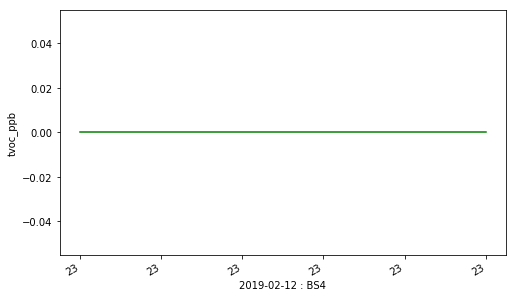

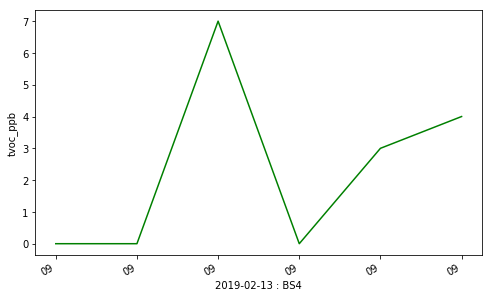

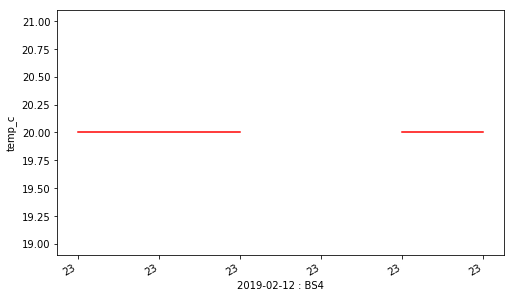

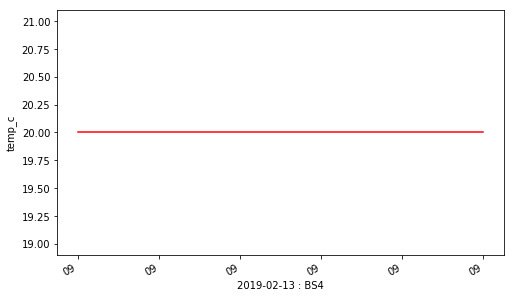

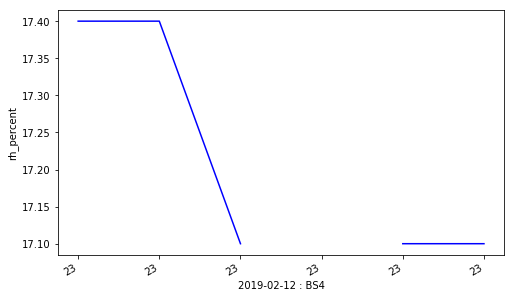

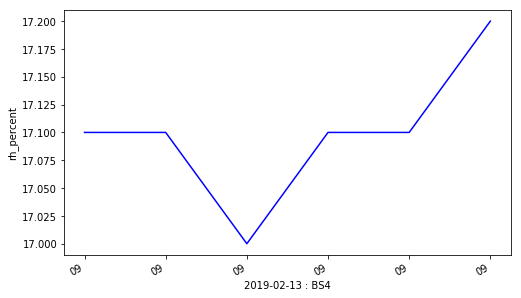

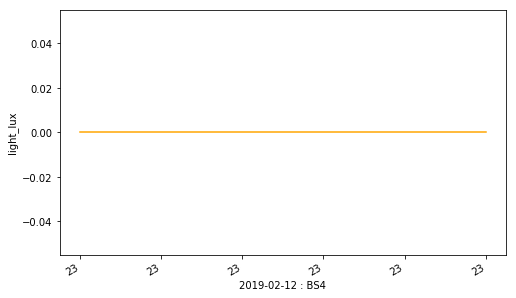

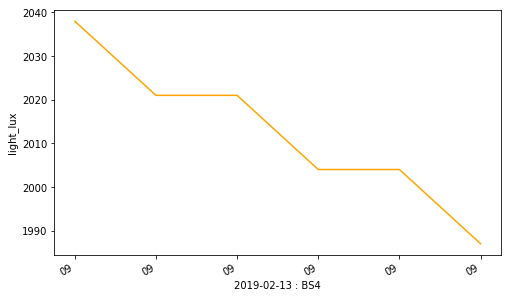

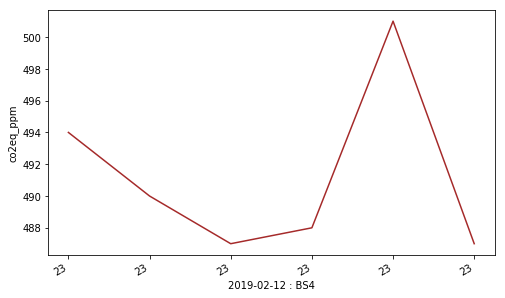

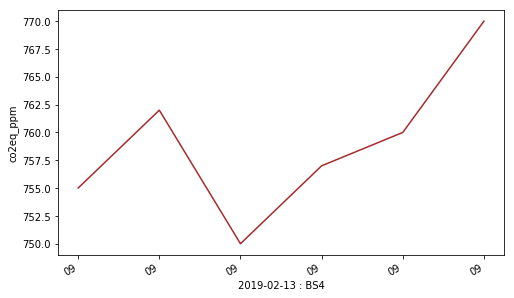

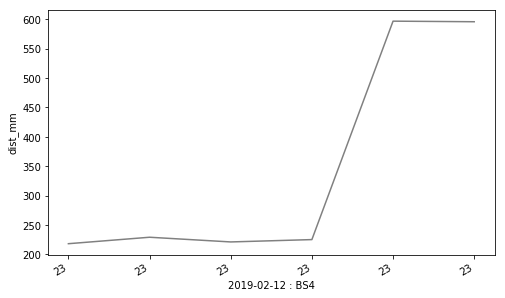

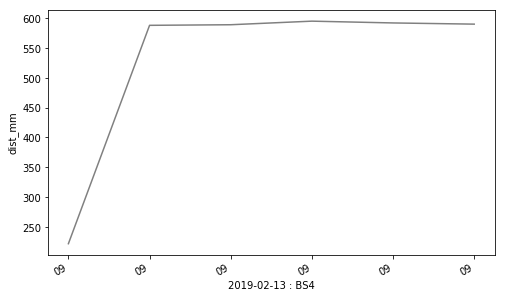

BS5


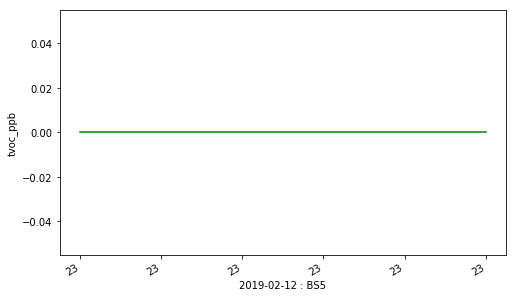

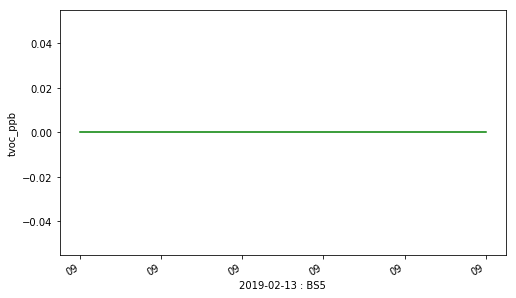

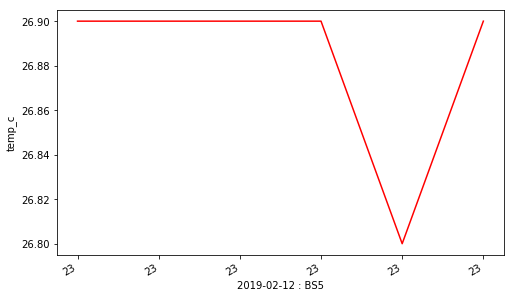

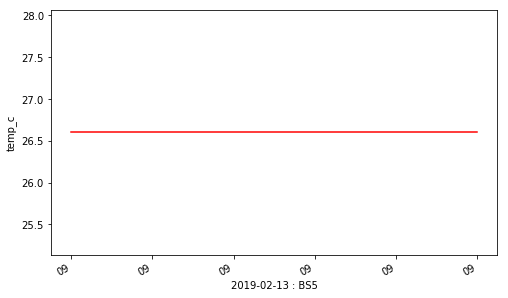

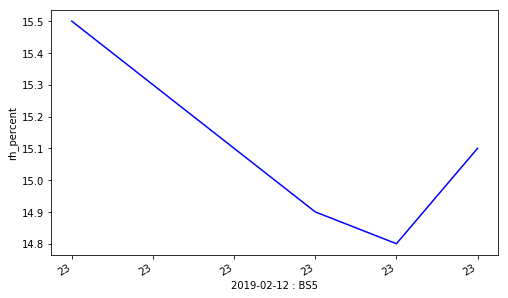

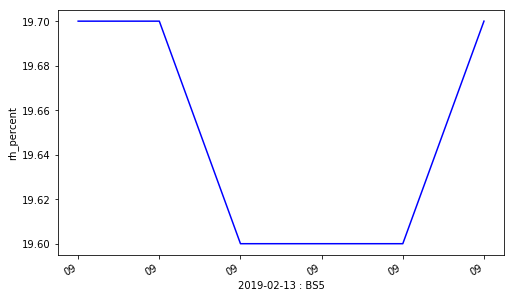

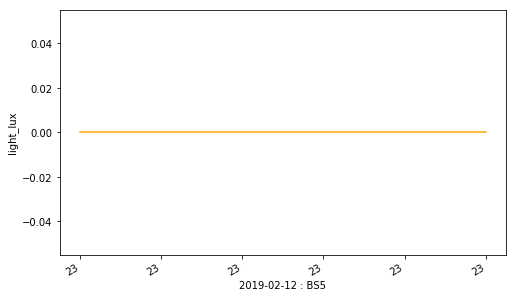

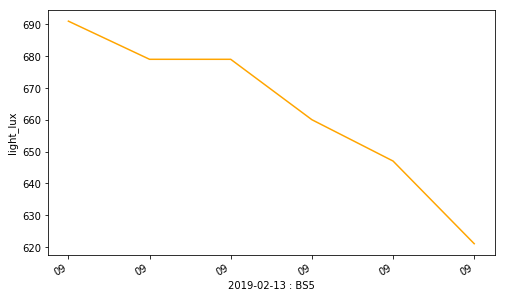

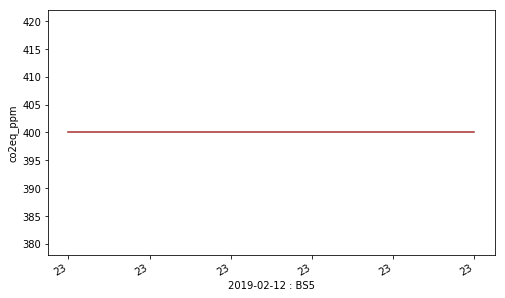

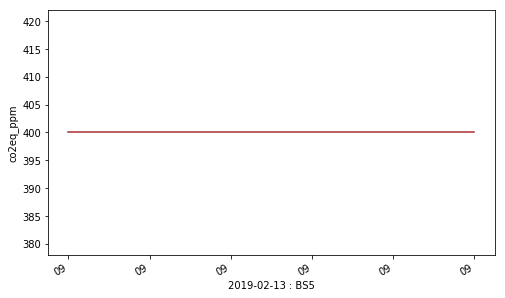

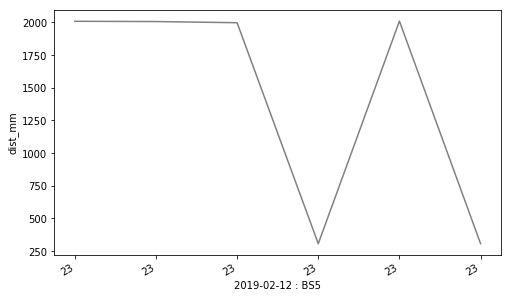

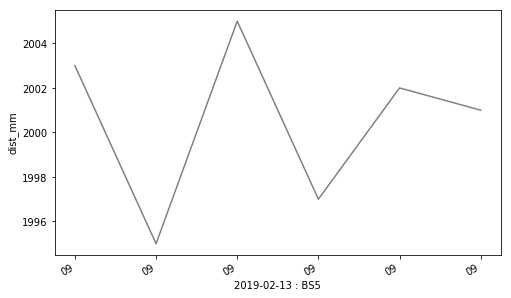

In [88]:
measures_to_plot = ['tvoc_ppb','temp_c','rh_percent','light_lux','co2eq_ppm','dist_mm']
#measures_to_plot = ['temp_c']
max_min = {'temp_c': [20, 30], 'rh_percent': [0,40], 'tvoc_ppb':[0,2000], 'co2eq_ppm':[0,2000]}

colors = ['green', 'red', 'blue', 'orange', 'brown', 'grey']

G = PlottingData(all_dfs, measures_to_plot, max_min, colors)

G.main()


In [22]:
## to do:
# check each time point
# add absolute humidity



# dataset analytics
number and percent of missing data values (nans)
percent of captured data points


In [92]:
percent_nans = {}

for df in all_dfs: 
    frame = all_dfs[df]
    end = frame['time_hour'].tail(1)
    perc = num_nans[df]/len(frame)
    high = 100 * perc.max()
    percent_nans[df] = high
print(percent_nans)

{'BS6': 4.722651554181693, 'BS5': 4.993673555461831, 'BS4': 5.2768021408262245, 'BS3': 5.055476766497039, 'BS2': 4.773703336636935, 'BS1': 30.87160108436704}
